# Configuration

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)

In [2]:
import sys, os

project_path = '../'
sys.path.append(project_path)

In [6]:
%load_ext autoreload
%autoreload 2

# Imports from environnement

In [3]:
from exploration.fall_study_stats import save_fractures_stats

# Reading DataFrames

In [4]:
import pandas as pd
import pyspark.sql.functions as fn

exposed_patients = spark.read.parquet("/shared/Observapur/staging/master/exposures/patients")
filtered_patients = spark.read.parquet("/shared/Observapur/staging/master/filter_patients/data")

outcomes = spark.read.parquet("/shared/Observapur/staging/master/fractures/hospitalized_fractures/data")

outcomes = outcomes.filter(fn.col("start").between(pd.to_datetime('2011-01-01'), pd.to_datetime('2013-01-01')))

outcomes = outcomes.join(exposed_patients, on="patientID", how="inner")

outcomes = outcomes.join(filtered_patients, on="patientID", how="inner")

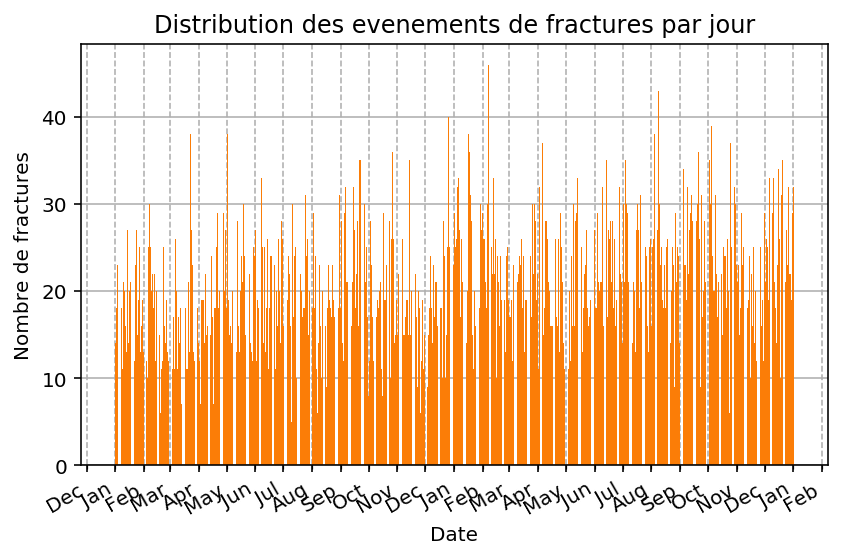

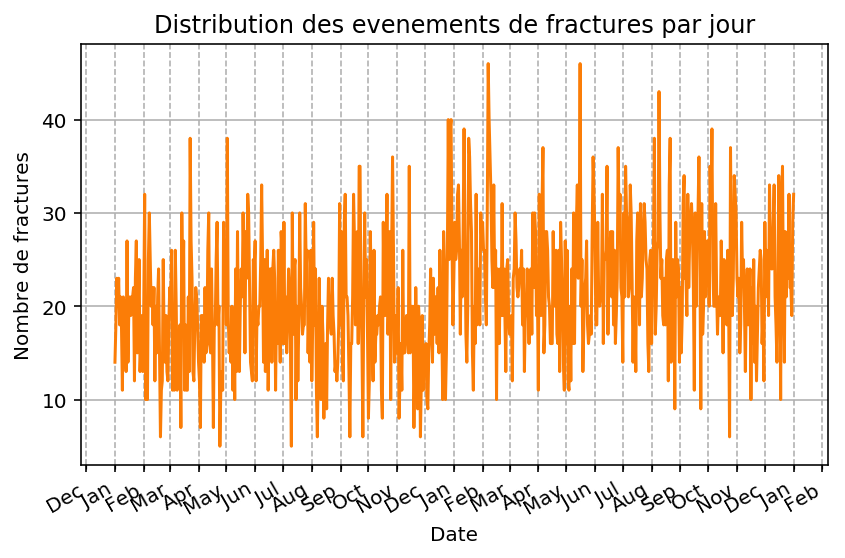

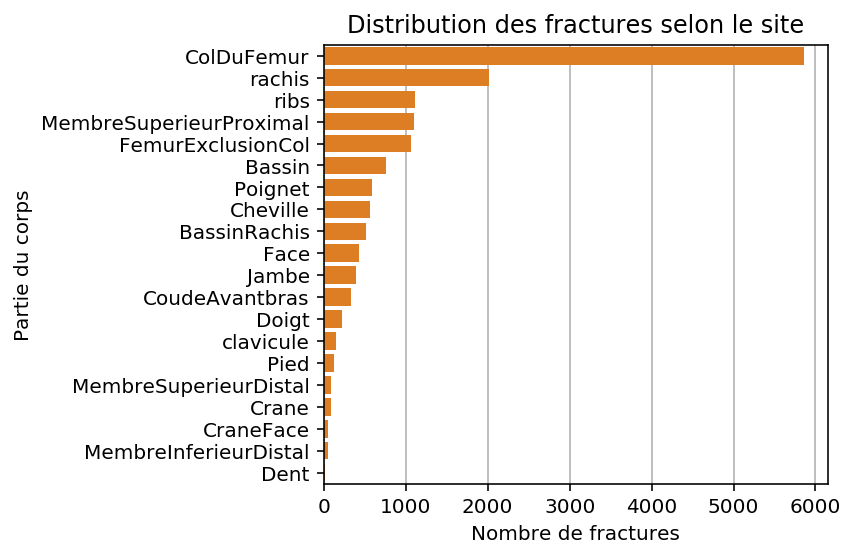

In [7]:
save_fractures_stats("/home/sebiat/stats/CNAM-310", outcomes)